In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib auto
import matplotlib
import open3d as o3d
matplotlib.rcParams.update({'font.size': 20})

import sys
import glob
sys.path.append('/nethome/abati7/flash/Work/mimic/third_party/RAFT-Stereo/')
sys.path.append('/nethome/abati7/flash/Work/mimic/third_party/RAFT-Stereo/core')

import argparse
import glob
import numpy as np
import torch
from tqdm import tqdm
from pathlib import Path
from raft_stereo import RAFTStereo
from utils.utils import InputPadder
from PIL import Image
from matplotlib import pyplot as plt

Using matplotlib backend: module://matplotlib_inline.backend_inline


In [16]:
def findObjImgPoints(calibrationDir, checkerboard=(7,10), draw=True):
    # termination criteria
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    row, col = checkerboard
     
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((row*col,3), np.float32)
    objp[:,:2] = np.mgrid[0:row,0:col].T.reshape(-1,2)
     
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d point in real world space
    imgpoints = [] # 2d points in image plane.
     
    images = glob.glob(calibrationDir+'/*.JPG')
    print(images)
    for fname in images:
        img = cv2.imread(fname)
        r,w,_ = img.shape
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        # gray = cv2.resize(gray, (int(w*0.25),int(r*0.25)))
        # Find the chess board corners
        ret, corners = cv2.findChessboardCorners(gray, (row,col), None)
        # If found, add object points, image points (after refining them)
        if ret == True:
            objpoints.append(objp)
            
            corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
            imgpoints.append(corners2)
            
            # Draw and display the corners
            out = cv2.drawChessboardCorners(img, (row,col), corners2, ret)
            corners2_reshaped = corners2.reshape(-1, 2)
            if draw:
                plt.scatter(corners2_reshaped[:, 0], corners2_reshaped[:, 1], c='r', s=10)
                plt.imshow(out)
                plt.show()
    return objpoints, imgpoints, gray.shape

In [17]:
def undistortImg(img, origmtx, dist, newcameramtx, roi, crop=True):
    """
    img: cv2 image
    crop: should return crop to ROI (region of interest) or not
    """
    dst = cv2.undistort(img, origmtx, dist, None, newcameramtx)
    
    # crop the image
    if crop:
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w]
    
    return dst
# dst = undistortImg(img, mtx, dist, newcameramtx, roi)
# plt.imshow(dst)
# plt.show()

In [18]:
def getExtrinsics(imgPath, origmtx, dist, checkerboard=(7,10)):
    """
    checkerboard: provide with (rows, cols)
    """
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    
    img = cv2.imread(imgPath)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, checkerboard, None)
    row, col = checkerboard
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners,(11,11),(-1,-1),criteria)
    objp = np.zeros((row*col,3), np.float32)
    objp[:,:2] = np.mgrid[0:row,0:col].T.reshape(-1,2)
    # Find the rotation and translation vectors.
    ret,rvecs, tvecs = cv2.solvePnP(objp, corners2, mtx, dist)
    rotation, _ = cv2.Rodrigues(rvecs)
    return rotation, tvecs

In [19]:
def rotation_matrix_from_euler(angles: tuple) -> np.ndarray:
    """
    Computes the rotation matrix from Euler angles (in radians).
    """
    rx, ry, rz = angles

    # Rotation matrix around the x-axis
    Rx = np.array([[1, 0, 0],
                   [0, np.cos(rx), -np.sin(rx)],
                   [0, np.sin(rx), np.cos(rx)]])
    
    # Rotation matrix around the y-axis
    Ry = np.array([[np.cos(ry), 0, np.sin(ry)],
                   [0, 1, 0],
                   [-np.sin(ry), 0, np.cos(ry)]])
    
    # Rotation matrix around the z-axis
    Rz = np.array([[np.cos(rz), -np.sin(rz), 0],
                   [np.sin(rz), np.cos(rz), 0],
                   [0, 0, 1]])
    
    # Combine the rotations: R = Rz * Ry * Rx
    R = np.dot(Rz, np.dot(Ry, Rx))
    
    return R

def compute_relative_extrinsics(R1: tuple, T1: np.ndarray, R2: tuple, T2: np.ndarray) -> tuple:
    """
    Computes the relative extrinsic parameters (rotation and translation) between two cameras.
    """

    R_relative = np.dot(R2, np.linalg.inv(R1))
    T_relative = T2 - R_relative @ T1

    # R1 = rotation_matrix_from_euler(R1_angles)
    # R2 = rotation_matrix_from_euler(R2_angles)

    # R_relative = np.dot(np.linalg.inv(R1), R2)
    # T_relative = np.linalg.inv(R1) @ (T2 - T1)
    # R_relative = np.dot(np.linalg.inv(R2), R1)
    # T_relative = R_relative @ T1 - T2

    return R_relative, T_relative

In [20]:
def initRAFTModel():
    parser = argparse.ArgumentParser()
    parser.add_argument('--restore_ckpt', help="restore checkpoint", required=True)
    parser.add_argument('--save_numpy', action='store_true', help='save output as numpy arrays')
    parser.add_argument('-l', '--left_imgs', help="path to all first (left) frames", default="datasets/Middlebury/MiddEval3/testH/*/im0.png")
    parser.add_argument('-r', '--right_imgs', help="path to all second (right) frames", default="datasets/Middlebury/MiddEval3/testH/*/im1.png")
    parser.add_argument('--output_directory', help="directory to save output", default="demo_output")
    parser.add_argument('--mixed_precision', action='store_true', help='use mixed precision')
    parser.add_argument('--valid_iters', type=int, default=32, help='number of flow-field updates during forward pass')
    
    # Architecture choices
    parser.add_argument('--hidden_dims', nargs='+', type=int, default=[128]*3, help="hidden state and context dimensions")
    parser.add_argument('--corr_implementation', choices=["reg", "alt", "reg_cuda", "alt_cuda"], default="reg", help="correlation volume implementation")
    parser.add_argument('--shared_backbone', action='store_true', help="use a single backbone for the context and feature encoders")
    parser.add_argument('--corr_levels', type=int, default=4, help="number of levels in the correlation pyramid")
    parser.add_argument('--corr_radius', type=int, default=4, help="width of the correlation pyramid")
    parser.add_argument('--n_downsample', type=int, default=2, help="resolution of the disparity field (1/2^K)")
    parser.add_argument('--context_norm', type=str, default="batch", choices=['group', 'batch', 'instance', 'none'], help="normalization of context encoder")
    parser.add_argument('--slow_fast_gru', action='store_true', help="iterate the low-res GRUs more frequently")
    parser.add_argument('--n_gru_layers', type=int, default=3, help="number of hidden GRU levels")
    argss = "--restore_ckpt /nethome/abati7/flash/Work/mimic/third_party/RAFT-Stereo/models/raftstereo-middlebury.pth --corr_implementation alt --mixed_precision"
    args = parser.parse_args(argss.split(" "))
    
    model = torch.nn.DataParallel(RAFTStereo(args), device_ids=[0])
    model.load_state_dict(torch.load(args.restore_ckpt))
    
    model = model.module
    model.to("cuda:0")
    model.eval()
    return model

In [21]:
DEVICE = 'cuda'

def load_image(imfile, resize=None):
    # img = np.array(Image.open(imfile)).astype(np.uint8)
    # img = torch.from_numpy(img).permute(2, 0, 1).float()
    # return img[None].to(DEVICE)
    origimg = cv2.imread(imfile)
    img = cv2.cvtColor(origimg, cv2.COLOR_BGR2RGB)
    if resize:
        img = cv2.resize(img, resize, cv2.INTER_AREA)
    # -> C,H,W
    # Normalization done in the model itself.
    return torch.from_numpy(img).permute(2, 0, 1).unsqueeze(0).float().to(DEVICE), origimg.shape




In [33]:
def getPointCloud(disparity_map, Q, rectifyRotation, Rw2c, Tw2c, weird=False):
    pixel_wise_disparities = disparity_map
    points_3D = cv2.reprojectImageTo3D(pixel_wise_disparities, Q)
    realPoints3dcam = np.linalg.inv(rectifyRotation) @ points_3D[:,:,:,None]

    if weird:
        realPoints3d = Rw2c @ realPoints3dcam + T1 # rotation_matrix_from_euler(R1_angles) @ realPoints3dcam + T1 #wtf is happening, wait nvm this may be right
    else: 
        realPoints3d = np.linalg.inv(Rw2c) @ (realPoints3dcam - Tw2c) # rotation_matrix_from_euler(R1_angles) @ realPoints3dcam + T1 #wtf is happening, wait nvm this may be right
    
    return realPoints3d, realPoints3dcam

In [24]:
def getXYZgivenPixel(pc, pixel):
    x,y = pixel
    return pc[x,y]

In [54]:
a = np.array([[2,3],[4,5]])
float(a[0][-1])

3.0

In [25]:
#test
objpoints, imgpoints, shapeOfCalibImg = findObjImgPoints("calibrationPhotos", draw=False)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, shapeOfCalibImg[::-1], None, None)
mean_error = 0
for i in range(len(objpoints)):
    imgpoints2, _ = cv2.projectPoints(objpoints[i], rvecs[i], tvecs[i], mtx, dist)
    error = cv2.norm(imgpoints[i], imgpoints2, cv2.NORM_L2)/len(imgpoints2)
    mean_error += error
 
print( "total error: {}".format(mean_error/len(objpoints)) )

h, w = shapeOfCalibImg[:2]
newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))

R1_w2c, T1_w2c = getExtrinsics("leftreal.JPG", mtx, dist)
R2_w2c, T2_w2c = getExtrinsics("rightreal.JPG", mtx, dist)

img_lefto = cv2.imread("leftreal.JPG")
img_left = undistortImg(img_lefto, mtx, dist, newcameramtx, roi)

img_right = cv2.imread("rightreal.JPG")
img_right = undistortImg(img_right, mtx, dist, newcameramtx, roi)

Kl = newcameramtx
Kr = newcameramtx
Dl = np.zeros(5)
Dr = np.zeros(5)
T1 = T1_w2c
T2 = T2_w2c
R1o = R1_w2c
R2o = R2_w2c

R, T = compute_relative_extrinsics(R1o, T1, R2o, T2)
R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(Kl, Dl, Kr, Dr, img_left.shape[:2][::-1], R, T)
xmap1, ymap1 = cv2.initUndistortRectifyMap(Kl, Dl, R1, P1, img_left.shape[:2][::-1], cv2.CV_32FC1)
xmap2, ymap2 = cv2.initUndistortRectifyMap(Kr, Dr, R2, P2, img_left.shape[:2][::-1], cv2.CV_32FC1)
left_img_rectified = cv2.remap(img_left, xmap1, ymap1, cv2.INTER_LINEAR)
right_img_rectified = cv2.remap(img_right, xmap2, ymap2, cv2.INTER_LINEAR)

['calibrationPhotos/IMG_7267.JPG', 'calibrationPhotos/IMG_7269.JPG', 'calibrationPhotos/IMG_7271.JPG', 'calibrationPhotos/IMG_7268.JPG', 'calibrationPhotos/IMG_7266.JPG', 'calibrationPhotos/IMG_7270.JPG', 'calibrationPhotos/IMG_7265.JPG', 'calibrationPhotos/IMG_7263.JPG', 'calibrationPhotos/IMG_7264.JPG']
total error: 0.016714222342677186


In [ ]:
img_left = cv2.imread(r'images/leftrgb.png')
img_right = cv2.imread(r'images/rightrgb.png')

Kl = np.array([[386.27, 0, 240], [0, 386.27, 160], [0, 0, 1]])
Kr = np.array([[386.27, 0, 240], [0, 386.27, 160], [0, 0, 1]])
Dl = np.zeros(5)
Dr = np.zeros(5)
T1 = np.array([[-0.1], [0.1], [1]])
T2 = np.array([[0.1], [0.1], [1]])
R1_angles = (0.4, 0, -0.1)
R2_angles = (0.4, 0, 0.1)

R, T = compute_relative_extrinsics(rotation_matrix_from_euler(R1_angles), T1, rotation_matrix_from_euler(R2_angles), T2)
R1, R2, P1, P2, Q, validRoi1, validRoi2 = cv2.stereoRectify(Kl, Dl, Kr, Dr, (480, 320), R, T)
xmap1, ymap1 = cv2.initUndistortRectifyMap(Kl, Dl, R1, P1, (480, 320), cv2.CV_32FC1)
xmap2, ymap2 = cv2.initUndistortRectifyMap(Kr, Dr, R2, P2, (480, 320), cv2.CV_32FC1)
left_img_rectified = cv2.remap(img_left, xmap1, ymap1, cv2.INTER_LINEAR)
right_img_rectified = cv2.remap(img_right, xmap2, ymap2, cv2.INTER_LINEAR)

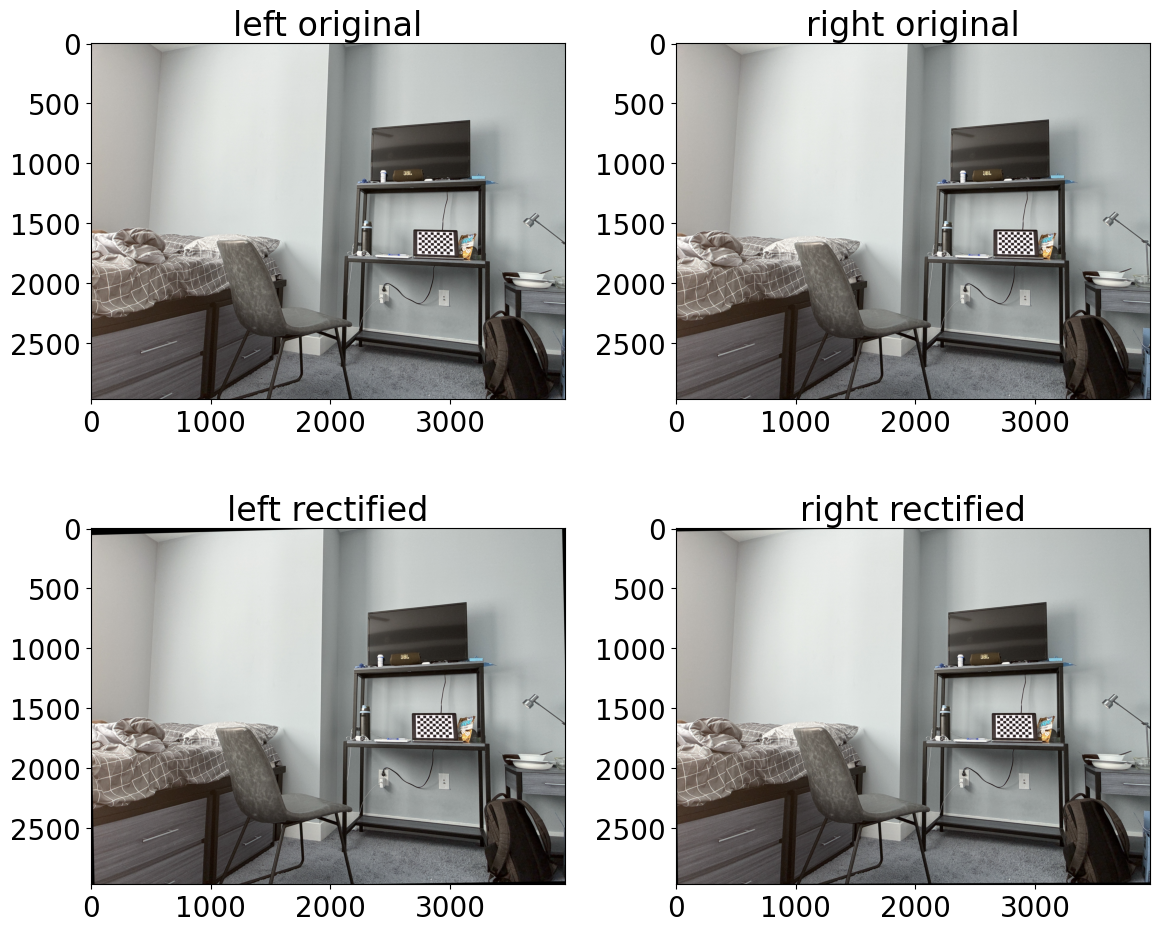

In [26]:
plt.figure(0, figsize=(12,10))
plt.subplot(221)
plt.title('left original')
plt.imshow(img_left, cmap='gray')
plt.subplot(222)
plt.title('right original')
plt.imshow(img_right, cmap='gray')
plt.subplot(223)
plt.title('left rectified')
plt.imshow(left_img_rectified, cmap='gray')
plt.subplot(224)
plt.title('right rectified')
plt.imshow(right_img_rectified, cmap='gray')
plt.tight_layout()
plt.show()

In [27]:
cv2.imwrite('leftstereo.png', left_img_rectified)
cv2.imwrite('rightstereo.png', right_img_rectified)

True

In [28]:
model = initRAFTModel()

/tmp/ipykernel_3563762/3326076253.py:25: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(args.restore_ckpt))


In [29]:
image1, origshape = load_image("leftstereo.png")
image2, origshape = load_image("rightstereo.png")

padder = InputPadder(image1.shape, divis_by=32)
image1, image2 = padder.pad(image1, image2)
with torch.no_grad():
    _, flow_up = model(image1, image2, iters=32, test_mode=True)
flow_up = padder.unpad(flow_up).squeeze()
flow_up = -flow_up.detach().cpu().numpy().squeeze()

# disparity_map = cv2.resize(flow_up, origshape[:2][::-1], cv2.INTER_NEAREST)
# x_scale = origshape[1] / float(1280)
# disparity_map *= np.float32(x_scale)

# disparity_map.shape

/nethome/abati7/flash/Work/mimic/third_party/RAFT-Stereo/core/raft_stereo.py:77: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/nethome/abati7/flash/miniconda3/envs/mim/lib/python3.11/site-packages/torch/functional.py:513: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3609.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/nethome/abati7/flash/Work/mimic/third_party/RAFT-Stereo/core/raft_stereo.py:112: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


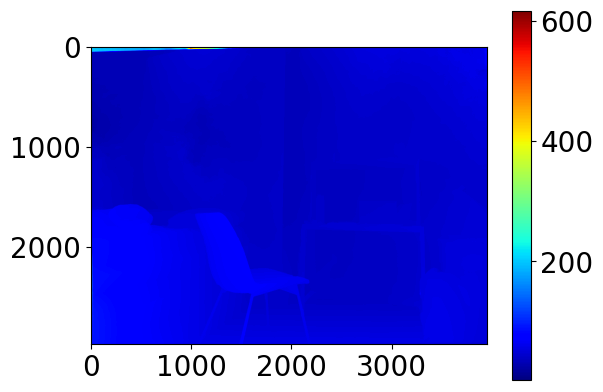

In [31]:
plt.imshow(flow_up, cmap="jet")
plt.colorbar()
plt.show()

In [34]:
realPoints3dWorldView, realPoints3dCamView = getPointCloud(flow_up, Q, R1, R1o, T1)
# realPoints3dWorldView, realPoints3dCamView = getPointCloud(flow_up, Q, R1, rotation_matrix_from_euler(R1_angles), T1)


In [35]:
realPoints3dWorldView.shape

(2967, 3956, 3, 1)

In [36]:
# Assume points_3D is your Nx3 NumPy array containing 3D points
# Example data: 3 points in 3D space
points_3D = realPoints3dWorldView.reshape((-1,3))

# Convert the NumPy array to an Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3D)

output_filename = "pcworld.ply"
o3d.io.write_point_cloud(output_filename, pcd)

True

In [37]:
# Assume points_3D is your Nx3 NumPy array containing 3D points
# Example data: 3 points in 3D space
points_3D = realPoints3dCamView.reshape((-1,3))

# Convert the NumPy array to an Open3D point cloud
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points_3D)

output_filename = "pccam.ply"
o3d.io.write_point_cloud(output_filename, pcd)

True

In [31]:
origimg = cv2.imread("leftstereo.png")
img = cv2.cvtColor(origimg, cv2.COLOR_BGR2RGB)

In [40]:
np.array(img).reshape((-1,3)).shape

(11737452, 3)